**Реализация рекомендательной системы на основе GNN (Graph Neural Network)**

**Цель:** научиться создавать рекомендательную систему на основе
графовых нейронных сетей (GNN), таких как легковесная графовая нейронная
сеть LightGCN, IRGNN (Item Relationship Graph Neural Network), применяя
методологию анализа графа взаимодействий пользователей и товаров/услуг,
научиться применять её для прогнозирования предпочтений пользователей,
оценить качество полученной модели на реальных данных.

In [1]:
!pip install torch_geometric >> None

# 1 часть – общий пример (1 балл)

In [1]:
import pandas as pd
from torch_geometric.data import Data
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('ratings.csv')

users = ratings['userId'].unique()
items = ratings['movieId'].unique()

n_nodes = len(users) + len(items)

user_map = {u: i for i, u in enumerate(users)}
item_map = {m: len(users) + i for i, m in enumerate(items)}

In [3]:
edges = ratings[['userId', 'movieId']].values
edge_index = torch.tensor([
    [user_map[u] for u, m in edges],
    [item_map[m] for u, m in edges]
], dtype=torch.long)

edge_label = torch.tensor(ratings['rating'].values, dtype=torch.float)

x = torch.eye(n_nodes)

scaler = MinMaxScaler((0, 1))
labels = torch.tensor(scaler.fit_transform(edge_label.unsqueeze(1)).squeeze(),
                      dtype=torch.float)

In [4]:
edge_indices = torch.arange(edge_index.shape[1])
train_idx, test_idx = train_test_split(edge_indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(edge_index.shape[1], dtype=torch.bool)
test_mask = torch.zeros(edge_index.shape[1], dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

In [5]:
data = Data(x=x, edge_index=edge_index, y=labels,
            train_mask=train_mask, test_mask=test_mask)
data

Data(x=[10334, 10334], edge_index=[2, 100836], y=[100836], train_mask=[100836], test_mask=[100836])

In [6]:
class RecommenderModel(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_layers=2):
        super().__init__()
        self.convs = torch.nn.ModuleList()

        if num_layers == 1:
            self.convs.append(GCNConv(num_features, 1))
        else:
            self.convs.append(GCNConv(num_features, hidden_channels))
            for _ in range(num_layers - 2):
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.convs.append(GCNConv(hidden_channels, 1))

    def forward(self, x, edge_index, edge_pairs):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs) - 1:
                x = F.relu(x)

        source_emb = x[edge_pairs[0]]
        target_emb = x[edge_pairs[1]]
        scores = (source_emb * target_emb).sum(dim=1)
        return scores

100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


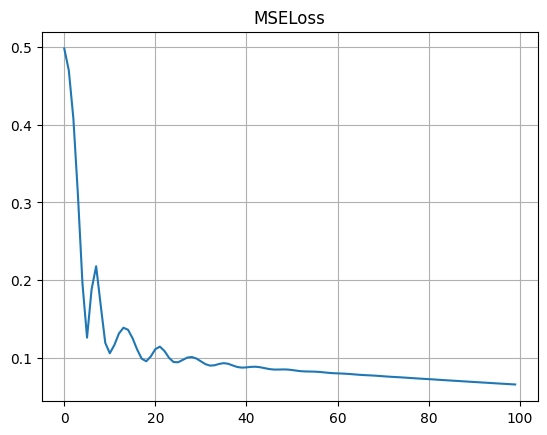

In [7]:
model = RecommenderModel(num_features=n_nodes, hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_index)[data.train_mask]
    loss = criterion(out, data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

losses = []
for epoch in tqdm(range(100)):
    losses.append(train())

plt.title('MSELoss')
plt.plot(losses)
plt.grid(True)
plt.show()

In [8]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index, data.edge_index)[data.test_mask]
        mse_loss = criterion(pred, data.y[data.test_mask])
    return float(mse_loss)

test_mse = evaluate(model, data)
print(f'Test MSE: {test_mse:.4f}')

Test MSE: 0.0714


In [9]:
data.edge_index, data.test_mask, data.y

(tensor([[   0,    0,    0,  ...,  609,  609,  609],
         [ 610,  611,  612,  ..., 3731, 2002, 3483]]),
 tensor([False, False, False,  ..., False, False,  True]),
 tensor([0.7778, 0.7778, 0.7778,  ..., 1.0000, 1.0000, 0.5556]))

In [10]:
model(data.x, data.edge_index, data.edge_index[:, -1].unsqueeze(dim=1)), data.y[-1]

(tensor([0.4677], grad_fn=<SumBackward1>), tensor(0.5556))

7. Самостоятельное задание

* Проведите гиперпараметризацию модели, выбрав оптимальное количество
слоёв и размерность скрытых признаков.

* Добавьте дополнительные признаки пользователей и объектов (пол,
возраст, жанр фильма и др.) и посмотрите влияние на точность рекомендаций.

In [11]:
layer_options = [1, 2, 3]
hidden_options = [8, 16, 32, 64]
results = []

for num_layers in layer_options:
    for hidden_channels in hidden_options:

        model = RecommenderModel(n_nodes, hidden_channels, num_layers)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = torch.nn.MSELoss()

        for epoch in tqdm(range(40), leave=False):
            train()
        test_mse = round(evaluate(model, data), 4)
        print(f'num_layers: {num_layers} | hidden_channels: {hidden_channels} | test_mse: {test_mse}')

        results.append((num_layers, hidden_channels, test_mse))

best_params = sorted(results, key=lambda x: x[2])[0]
print(f'\nЛучшие параметры: {best_params}')

num_layers: 1 | hidden_channels: 8 | test_mse: 0.0887


num_layers: 1 | hidden_channels: 16 | test_mse: 0.0884


num_layers: 1 | hidden_channels: 32 | test_mse: 0.0884


num_layers: 1 | hidden_channels: 64 | test_mse: 0.0887


num_layers: 2 | hidden_channels: 8 | test_mse: 0.091


num_layers: 2 | hidden_channels: 16 | test_mse: 0.0923


num_layers: 2 | hidden_channels: 32 | test_mse: 0.0915


num_layers: 2 | hidden_channels: 64 | test_mse: 0.0916


num_layers: 3 | hidden_channels: 8 | test_mse: 0.0918


num_layers: 3 | hidden_channels: 16 | test_mse: 0.0917


num_layers: 3 | hidden_channels: 32 | test_mse: 0.095


num_layers: 3 | hidden_channels: 64 | test_mse: 0.0992

Лучшие параметры: (1, 16, 0.0884)


# 2 часть – Применение легковесной графовой нейронной сети LightGCN (1 балл)

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.nn.models import LightGCN
import random
from torch_geometric.data import Data

In [2]:
data = pd.read_csv('fashion_products.csv')

users = data['User ID'].unique()
items = data['Product ID'].unique()

n_nodes = len(users) + len(items)

user_map = {u: i for i, u in enumerate(users)}
item_map = {m: len(users) + i for i, m in enumerate(items)}

In [3]:
edges = data[['User ID', 'Product ID']].values
edge_index = torch.tensor([
    [user_map[u] for u, m in edges],
    [item_map[m] for u, m in edges]
], dtype=torch.long)
edge_set = set(zip(edge_index[0].tolist(), edge_index[1].tolist()))

edges_neg = []
while len(edges_neg) < len(edges):
    u = random.randint(0, len(user_map) - 1)
    v = random.randint(len(user_map), len(user_map) + len(item_map) - 1)
    if (u, v) not in edge_set:
        edges_neg.append((u, v))
edge_index_neg = torch.tensor([
    [u for u, v in edges_neg],
    [v for u, v in edges_neg]
], dtype=torch.long)

edge_index = torch.concat((edge_index, edge_index_neg), dim=1)
edge_index

tensor([[  0,   1,   2,  ...,  92,  28,  58],
        [100, 101, 102,  ..., 739, 960, 304]])

In [4]:
edge_label = torch.cat([
    torch.ones(len(edges)),
    torch.zeros(len(edges_neg))
])

edge_indices = torch.arange(edge_index.shape[1])
train_idx, test_idx = train_test_split(edge_indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(edge_index.shape[1], dtype=torch.bool)
test_mask = torch.zeros(edge_index.shape[1], dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

data = Data(edge_index=edge_index, y=edge_label,
            train_mask=train_mask, test_mask=test_mask)
data

Data(edge_index=[2, 2000], y=[2000], train_mask=[2000], test_mask=[2000])

In [5]:
layer_options = [1, 2, 3]
hidden_options = [8, 16, 32, 64]
results = []

for num_layers in layer_options:
    for hidden_channels in hidden_options:

        model = LightGCN(n_nodes, hidden_channels, num_layers)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(50):
            model.train()
            optimizer.zero_grad()
            pred = model(data.edge_index, edge_label_index=data.edge_index[:, data.train_mask])
            loss = model.link_pred_loss(pred, data.y[data.train_mask])
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            pred = model(data.edge_index, edge_label_index=data.edge_index[:, data.test_mask])
            loss = model.link_pred_loss(pred, data.y[data.test_mask]).item()
        print(f'num_layers: {num_layers} | hidden_channels: {hidden_channels} | BCEWithLogitsLoss.: {loss}')

        results.append((num_layers, hidden_channels, loss))

best_params = sorted(results, key=lambda x: x[2])[0]
print(f'\nЛучшие параметры: {best_params}')

num_layers: 1 | hidden_channels: 8 | BCEWithLogitsLoss.: 0.7026294469833374
num_layers: 1 | hidden_channels: 16 | BCEWithLogitsLoss.: 0.7023831009864807
num_layers: 1 | hidden_channels: 32 | BCEWithLogitsLoss.: 0.6944474577903748
num_layers: 1 | hidden_channels: 64 | BCEWithLogitsLoss.: 0.7152628898620605
num_layers: 2 | hidden_channels: 8 | BCEWithLogitsLoss.: 0.6941636800765991
num_layers: 2 | hidden_channels: 16 | BCEWithLogitsLoss.: 0.6931037306785583
num_layers: 2 | hidden_channels: 32 | BCEWithLogitsLoss.: 0.697109043598175
num_layers: 2 | hidden_channels: 64 | BCEWithLogitsLoss.: 0.6941418647766113
num_layers: 3 | hidden_channels: 8 | BCEWithLogitsLoss.: 0.6911461353302002
num_layers: 3 | hidden_channels: 16 | BCEWithLogitsLoss.: 0.6964939832687378
num_layers: 3 | hidden_channels: 32 | BCEWithLogitsLoss.: 0.6946470737457275
num_layers: 3 | hidden_channels: 64 | BCEWithLogitsLoss.: 0.6973477005958557

Лучшие параметры: (3, 8, 0.6911461353302002)


In [6]:
data.test_mask[10:30], data.test_mask[30]

(tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False,  True]),
 tensor(True))

In [7]:
model(data.edge_index, data.edge_index[:, 0].unsqueeze(dim=1)), data.y[0]

(tensor([0.8322], grad_fn=<SumBackward1>), tensor(1.))

In [8]:
model(data.edge_index, data.edge_index[:, 30].unsqueeze(dim=1)), data.y[30]

(tensor([0.1626], grad_fn=<SumBackward1>), tensor(1.))

In [9]:
torch.sigmoid(model(data.edge_index, data.edge_index[:, 30].unsqueeze(dim=1)))

tensor([0.5405], grad_fn=<SigmoidBackward0>)

# 3 часть – Применение графовой нейронной сети IRGNN для реализации рекомендательной системы (2 балла)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from itertools import permutations
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GraphConv
import math

In [2]:
df = pd.read_csv('user_artists.dat', sep='\t', header=0)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
df.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [3]:
unique_items = df['artistID'].unique()
item2idx = {item: idx for idx, item in enumerate(unique_items)}
num_items = len(unique_items)

cooc = Counter()
for _, group in train_df.groupby('userID'):
    items = list(zip(group['artistID'], group['weight']))
    for (i, w_i), (j, w_j) in permutations(items, 2):
        if i != j:
            weight = math.log1p(min(w_i, w_j))
            cooc[(item2idx[i], item2idx[j])] += weight

edge_index = torch.tensor(list(cooc.keys()), dtype=torch.long).t()
edge_weight = torch.tensor(list(cooc.values()), dtype=torch.float)
edge_weight = (edge_weight - edge_weight.min()) / (edge_weight.max() - edge_weight.min())

data = Data(num_nodes=num_items,
            edge_index=edge_index,
            edge_attr=edge_weight)
data

Data(edge_index=[2, 1827890], edge_attr=[1827890], num_nodes=17632)

In [4]:
input_dim, hidden_dim, output_dim = 16, 32, 8
data.x = torch.randn((num_items, input_dim))

In [5]:
class IRGNN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GraphConv(in_dim, hid_dim)
        self.conv2 = GraphConv(hid_dim, out_dim)

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [6]:
model = IRGNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
for epoch in range(50+1):
    model.train()
    optimizer.zero_grad()
    embeddings = model(data.x, data.edge_index, data.edge_attr)
    src, dst = data.edge_index
    pred = (embeddings[src] * embeddings[dst]).sum(dim=1)
    loss = F.cross_entropy(pred, data.edge_attr)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch} — Loss: {loss.item():.4f}')

Epoch 0 — Loss: 8.9371
Epoch 10 — Loss: 0.3532
Epoch 20 — Loss: 0.1152
Epoch 30 — Loss: 0.1100
Epoch 40 — Loss: 0.1098
Epoch 50 — Loss: 0.1094


In [8]:
@torch.no_grad()
def recommend(user_id, top_k=10):
    listened = train_df[train_df['userID'] == user_id]['artistID'].tolist()
    idxs = [item2idx[a] for a in listened if a in item2idx]
    if not idxs:
        return []
    user_emb = embeddings[idxs].mean(dim=0)
    scores = embeddings @ user_emb
    scores[idxs] = -1e9
    top_idxs = scores.topk(top_k).indices.cpu().tolist()
    idx2item = {v: k for k, v in item2idx.items()}
    return [int(idx2item[i]) for i in top_idxs]

In [9]:
uid = int(test_df.iloc[0]['userID'])
print(f'Рекомендации для пользователя {uid}: {recommend(uid, top_k=10)}')

Рекомендации для пользователя 1761: [9356, 10633, 17587, 2710, 10642, 6379, 15148, 14346, 7509, 2075]
